# This is a test of this jupyter notebook in combiantion with Snorkel

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession
session = SnorkelSession()

In [2]:
from snorkel.parser import XMLMultiDocParser

xml_parser = XMLMultiDocParser(
    path='data/CDR_TrainingSet.BioC.xml',
    doc='.//document',
    text='.//passage/text/text()',
    id='.//id/text()')

In [3]:
from snorkel.parser import SentenceParser
from utils import CDRTagger

cdr_tagger = CDRTagger()
cdr_sent_parser = SentenceParser(fn=cdr_tagger.tag)

/home/davidnicholson/anaconda3/envs/p27/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


[========================================] 100%

Number of documents: 500
CPU times: user 9.1 s, sys: 188 ms, total: 9.29 s
Wall time: 1min 32s


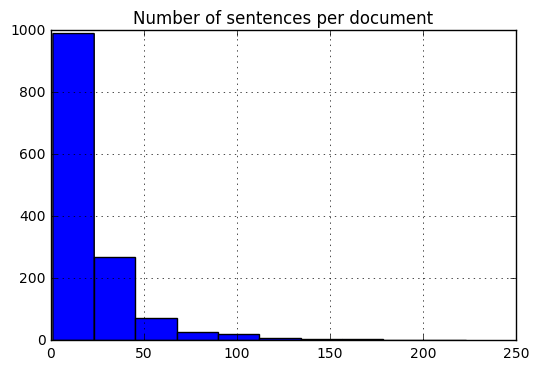

In [4]:
from snorkel.parser import CorpusParser

cp = CorpusParser(xml_parser, cdr_sent_parser, max_docs=500)
%time corpus = cp.parse_corpus(name='CDR Train', session=session)

In [5]:
session.add(corpus)
session.commit()

In [8]:
from snorkel.models import candidate_subclass

ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

In [7]:
from snorkel.candidates import PretaggedCandidateExtractor

ce = PretaggedCandidateExtractor(ChemicalDisease, ['Chemical', 'Disease'])

In [8]:
from snorkel.models import Corpus

for corpus_name in ['CDR Train']:
    corpus = session.query(Corpus).filter(Corpus.name == corpus_name).one()
    sentences = set()
    for document in corpus:
        for sentence in document.sentences:
            sentences.add(sentence)
    
    %time c = ce.extract(sentences, corpus_name + ' Candidates', session)
    session.add(c)
    print '{0} has {1} candidates'.format(corpus_name, len(c))
session.commit()

[========================================] 100%

CPU times: user 15.5 s, sys: 64 ms, total: 15.6 s
Wall time: 16.2 s
CDR Train has 4637 candidates


In [6]:
from snorkel.models import CandidateSet

train = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Train Candidates').one()

In [31]:
import re,sys
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

def LF_is_in_PharmDB(c):
    print c
    print c[0]
    print c[0].get_attrib_tokens()
    print c.chemical_cid
    print get_tagged_text(c)
    sys.exit(10)
    return 1

In [32]:
LFs = [LF_is_in_PharmDB]

In [33]:
from snorkel.annotations import LabelManager

label_manager = LabelManager()

In [34]:
%time L_train = label_manager.create(session, train, 'LF Labels1', f=LFs)
L_train

[=                                       ] 0%ChemicalDisease(Span("sodium bicarbonate", parent=42297, chars=[27,44], words=[5,6]), Span("penile pain", parent=42297, chars=[93,103], words=[18,19]))
Span("sodium bicarbonate", parent=42297, chars=[27,44], words=[5,6])
[u'sodium', u'bicarbonate']
D017693
Of the 19 patients without {{A}} added to the medication 11 (58%) complained of {{B}} due to the medication, while only 1 of the 19 men (5%) who received sodium bicarbonate complained of penile pain.


SystemExit: 10